In [58]:
#######################################################
####       Example pipeline with medkit            ####
####                                               ####
####  It tests two tools (NER1 and NER2) for       ####
####  recognizing drug names in clinical texts,    ####
####  compare their performance and output 2 texts ####
####  annotated with the tool with the best perf.  #### 
#######################################################

# To install medkit: 
# https://medkit.readthedocs.io/en/stable/user_guide/install.html

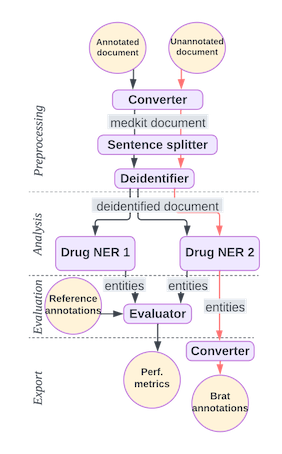
<img src="pipeline.png" align="left"/>

In [68]:
## Download two clinical texts, with drug entites manually annotated
import requests
import os
import tarfile

#remote
url_root = "https://raw.githubusercontent.com/TeamHeka/data/main/"
archive="data.tar.gz"
url=url_root+archive

#local
path="./"

response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path)

mypath=path+"data/mtsamplesen/annotated_doc/"
print("Data dir: "+mypath)

Data dir: ./data/mtsamplesen/annotated_doc/


In [60]:
## Read text doc as medkit documents
from pathlib import Path
from medkit.core.text import TextDocument

docs = TextDocument.from_dir(path=Path(mypath), pattern='[A-Z0-9].txt', encoding='utf-8')

In [62]:
## Create and run a three-step doc pipeline that: 
# 1) split sentences in texts 
# 2) Recognize drug entities with NER1: a dictionnary-based approach named UMLSMatcher 
# 3) Recognize drug entities with NER2: a Transformer-based approach, see https://huggingface.co/samrawal/bert-large-uncased_med-ner
from medkit.core import DocPipeline
from medkit.core import Pipeline
from medkit.core import PipelineStep
from medkit.text.segmentation import SentenceTokenizer
from medkit.text.ner import UMLSMatcher
from medkit.text.ner.hf_entity_matcher import HFEntityMatcher

# Def of the first step =============
# By default, SentenceTokenizer will use a list of punctuation chars to detect sentences.
sentence_tokenizer = SentenceTokenizer(
    # Label of the segments created and returned by the operation
    output_label="sentence",
    # Keep the punctuation character inside the sentence segments
    keep_punct=True,
    # Also split on newline chars, not just punctuation characters
    split_on_newlines=True,
)

# Def of the second step =============
# Codes of UMLS semantic groups to take into account
umls_semgroups = ["CHEM"]  # chemical (the UMLS semantic group to take into account)
umls_matcher = UMLSMatcher(
    # Directory containing the UMLS files with terms and concepts
    umls_dir=path+"data/UMLS/2023AB/META/",
    # Language to use (English)
    language="ENG",
    # Where to store the temp term database of the matcher
    cache_dir=".umls_cache/",
    # Semantic groups to consider
    semgroups=umls_semgroups,
    # Don't be case-sensitive
    lowercase=True,
    # Convert special chars to ASCII before matching
    normalize_unicode=True,
    name="NER1"
)

# Def of the third step =============
bert_matcher = HFEntityMatcher(model="samrawal/bert-large-uncased_med-ner", name="NER2")# an alternate model: "Clinical-AI-Apollo/Medical-NER"


pipeline3 = Pipeline(steps=[
    PipelineStep(sentence_tokenizer, input_keys=["full_text"], output_keys=["sentence"]),
    # deidentification step could come here
    PipelineStep(umls_matcher, input_keys=["sentence"], output_keys=["ner1_drug"]), 
    PipelineStep(bert_matcher, input_keys=["sentence"], output_keys=["ner2_drug"])],
                                          input_keys=["full_text"],
                                          output_keys=["sentence", "ner1_drug", "ner2_drug"])

doc_pipeline = DocPipeline(pipeline=pipeline3)
doc_pipeline.run(docs)

100%|████████████████████████████████████████████████████████████████████████████████| 13.9k/13.9k [00:00<00:00, 1.87MB/s]


In [63]:
## Load medkit documents with their manual annotations made with Brat (our ground truth)
from medkit.io.brat import BratInputConverter

# Define an Input Converter to load brat text and annot in medkit docs
brat_converter = BratInputConverter()
ref_docs = brat_converter.load(dir_path=mypath)

In [64]:
## Compute some stats
print(f"Nb of docs: {len(docs)}")
    
i=0
for doc in docs:
    print ("Doc "+doc.uid+": ")
    # On annotations made by NER1 and NER2
    sentence_nb = len(doc.anns.get(label="sentence"))
    print(f"\t{sentence_nb} sentences,")
    ner1_drug_nb = len(doc.anns.get(label="chemical"))
    print(f"\t{ner1_drug_nb} drugs found with NER1,")  
    ner2_drug_nb = len(doc.anns.get(label="m"))
    print(f"\t{ner2_drug_nb} drugs found with NER2,")  
    
    # On the manual annotation (our ground truth)
    gt_nb = len(ref_docs[i].anns.get(label="Drug"))
    print(f"\t{gt_nb} drugs manually annotated.")  
    
    i=+1

Nb of docs: 2
Doc 0db3008c-300f-11ef-ac8a-be2893d1605a: 
	47 sentences,
	2 drugs found with NER1,
	5 drugs found with NER2,
	5 drugs manually annotated.
Doc 0db30b68-300f-11ef-ac8a-be2893d1605a: 
	120 sentences,
	17 drugs found with NER1,
	16 drugs found with NER2,
	15 drugs manually annotated.


In [66]:
## Evaluate performance metrics of the NER1 and NER2 tools
from medkit.text.metrics.ner import SeqEvalEvaluator
import pandas as pd

def results_to_df(_results, _title):
    results_list = list(_results.items())
    arranged_results = {"Entities": ['P', 'R', 'F1']}
    accuracy = round(results_list[4][1], 2)

    for i in range(5, len(results_list), 4):
        key = results_list[i][0][:-10]
        arranged_results[key] = [round(results_list[n][1], 2) for n in [i, i + 1, i + 2]]

    df = pd.DataFrame(arranged_results, index=[f"{_title} (acc={accuracy})", '', '']).T
    return df

predicted_entities1=[]
predicted_entities2=[]
dfs = []

for doc in docs:
    predicted_entities1.append(doc.anns.get(label="chemical"))
    predicted_entities2.append(doc.anns.get(label="m"))

# Annotations of NER1 are labelled as 'chemical', NER2 as 'm', but as 'Drug' in the ground truth
# The following dic enables remappings various labels of the same type of entites
remapping= {"chemical": "Drug", "m": "Drug"}
evaluator = SeqEvalEvaluator(return_metrics_by_label=True, average='weighted', labels_remapping=remapping) 
# eval of NER2
results1 = evaluator.compute(ref_docs, predicted_entities1)
dfs.append(results_to_df(_results=results1, _title="NER1"))
#print(results_to_df(_results=results1, _title="umls_matcher"))
# eval of NER2
results2 = evaluator.compute(ref_docs, predicted_entities2)
dfs.append(results_to_df(_results=results2, _title="NER2"))

print(pd.concat(dfs, axis=1))

         NER1 (acc=0.99)             NER2 (acc=1.0)            
Entities               P     R    F1              P     R    F1
Drug                0.89  0.85  0.87            0.9  0.95  0.93


In [67]:
## Read new unannotated documents
## Write annotations of tool NER2 in the brat format
from medkit.io.brat import BratOutputConverter

in_path=path+"data/mtsamplesen/unannotated_doc"
# reload raw documents
final_docs = TextDocument.from_dir(path=Path(in_path), pattern='[A-Z0-9].txt', encoding='utf-8')
# simplified pipeline, with only the best NER tool (NER2)
pipeline2 = Pipeline(steps=[
    PipelineStep(sentence_tokenizer, input_keys=["full_text"], output_keys=["sentence"]),
    # deidentification step could come here
    PipelineStep(bert_matcher, input_keys=["sentence"], output_keys=["ner2_drug"])],
                                          input_keys=["full_text"],
                                          output_keys=["ner2_drug"])

doc_pipeline2 = DocPipeline(pipeline=pipeline2)
doc_pipeline2.run(final_docs)

# filter annotations to keep only drug annotations
# sensitive information can also be removed here
output_docs=[]
for doc in final_docs:
    output_docs.append(TextDocument(text=doc.text, anns=doc.anns.get(label="m")))

# Define Output Converter with default params,
# transfer all annotations and attributes
brat_output_converter = BratOutputConverter()

out_path=path+"data/mtsamplesen/ner2_out/"

# save the annotation with the best tool (considering F1 only) in `out_path`
brat_output_converter.save(
  output_docs,  dir_path=out_path, doc_names=["ner2_6", "ner2_7"])

Annotations of the discharge summary 6.txt, displayed with Brat

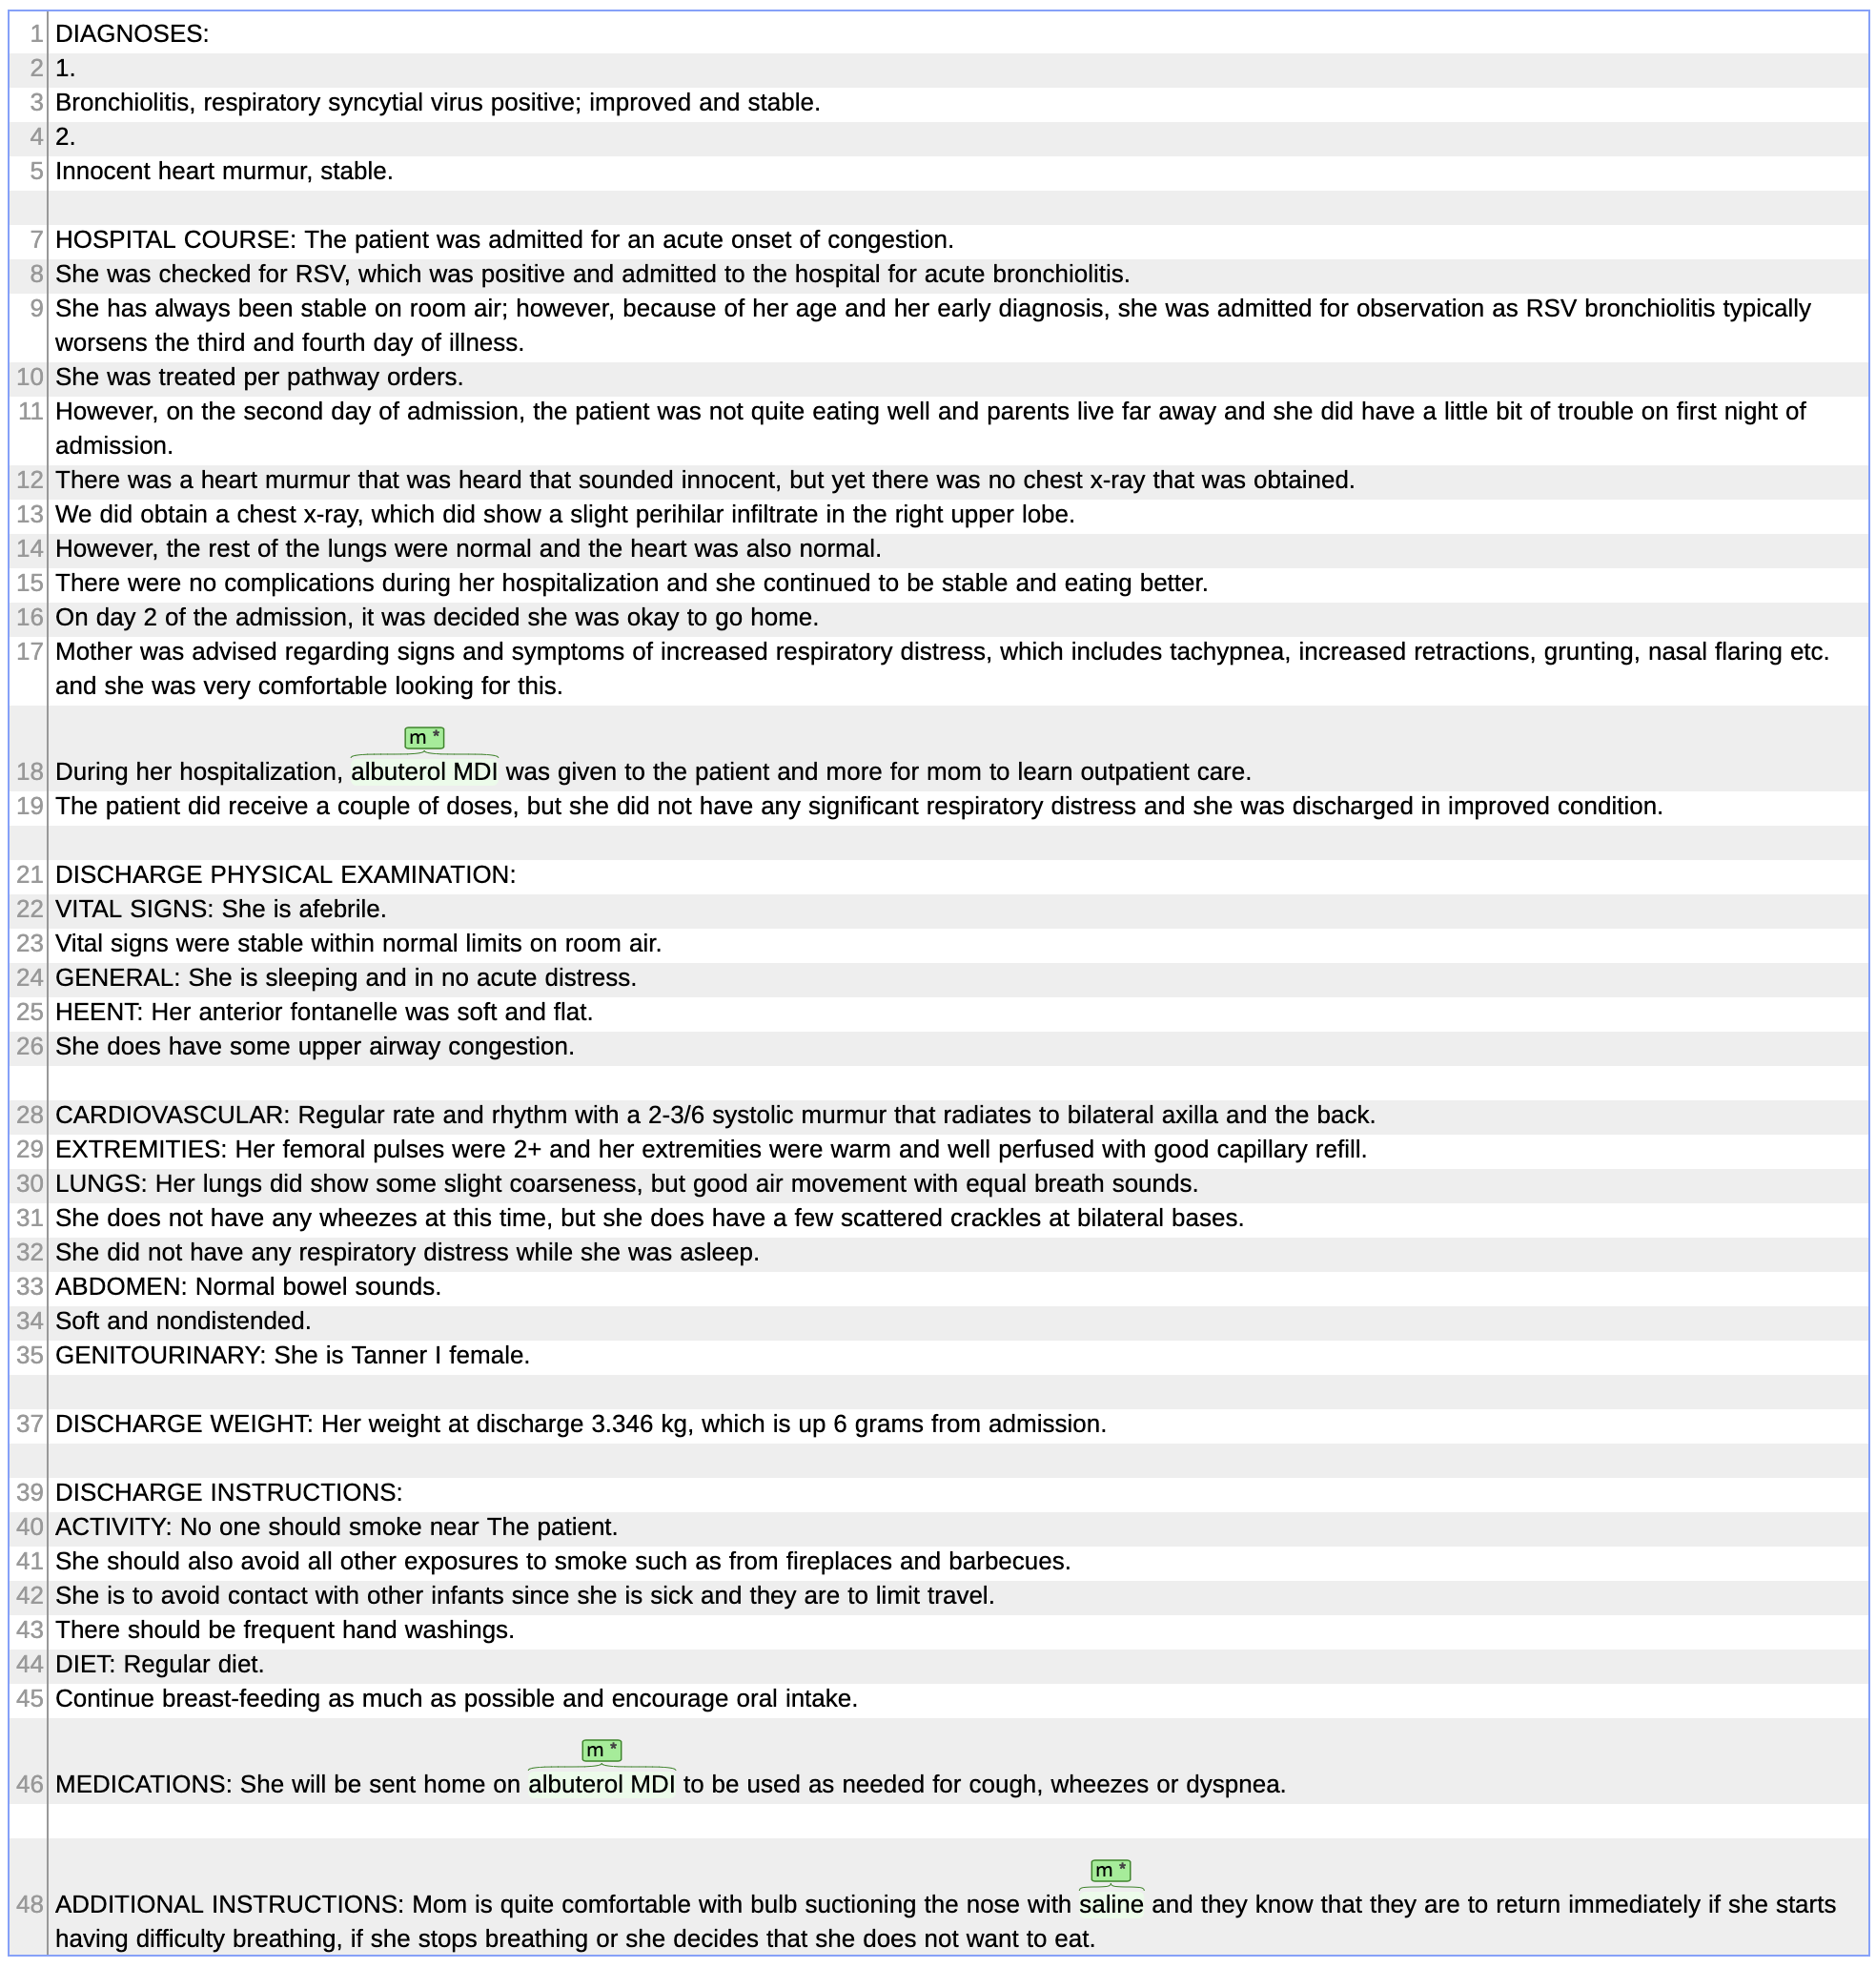

Annotations of the discharge summary 7.txt (partial view), displayed with Brat

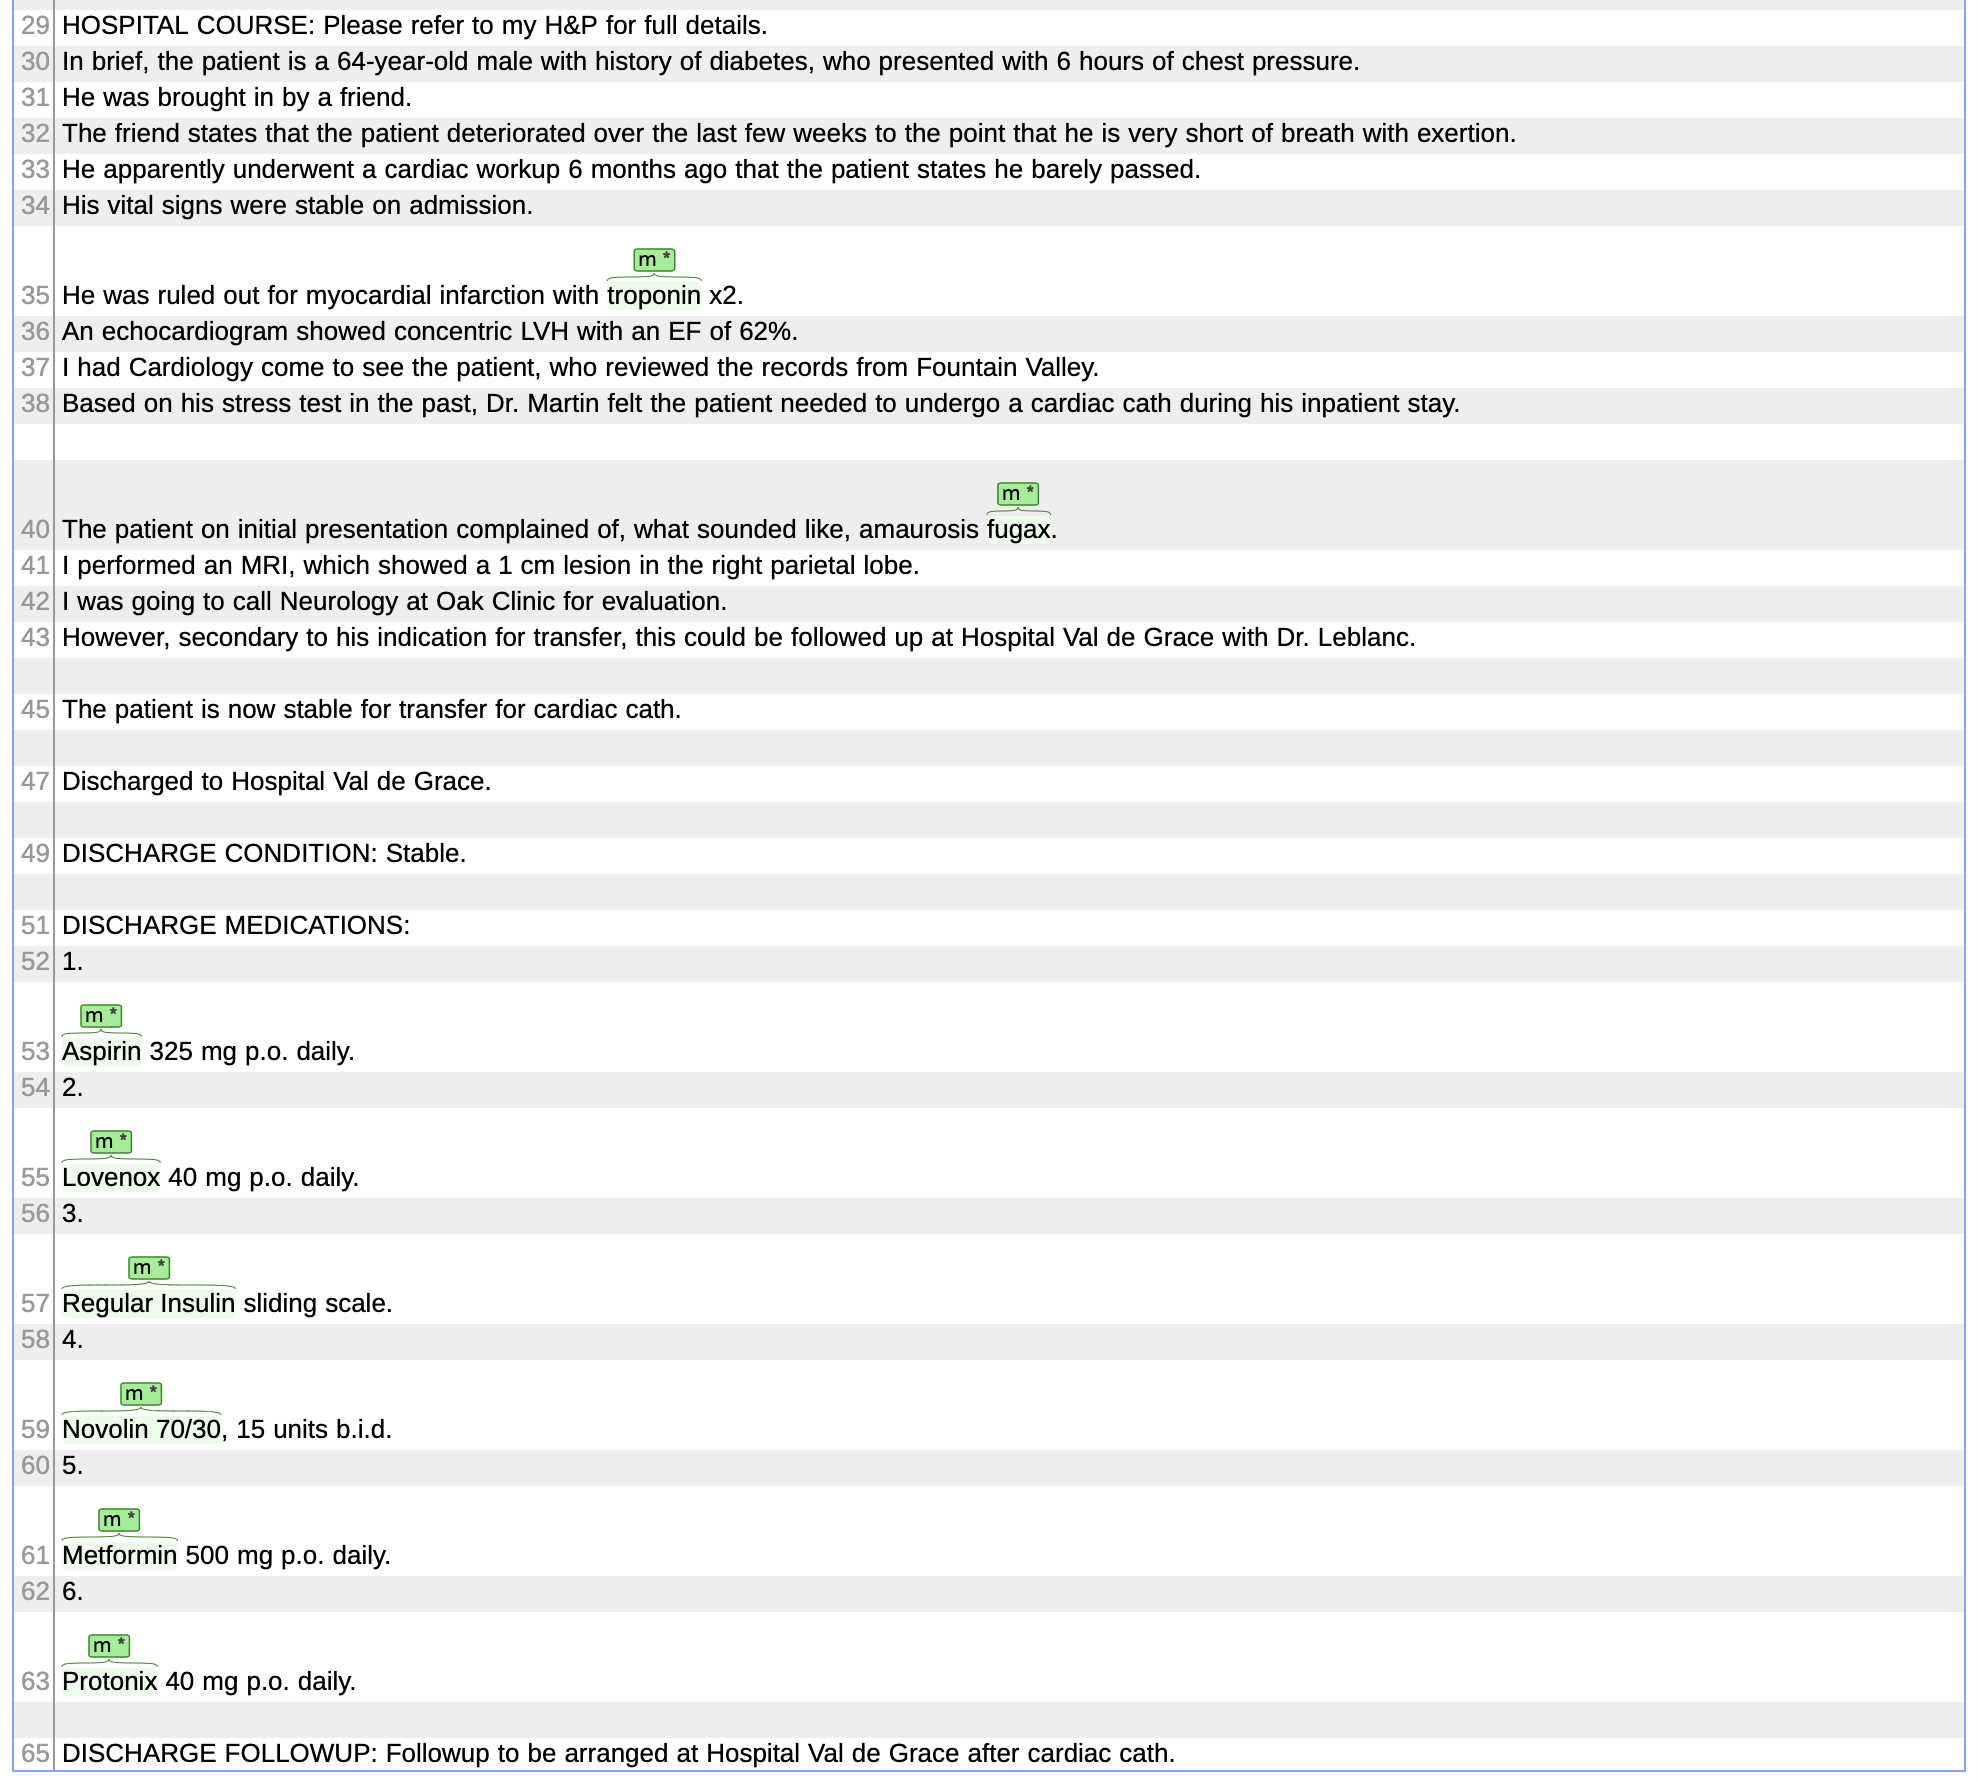

In [15]:
######################################################
######################################################